In [1]:
# Imports:
import os
import re
import statistics
import pandas as pd
import numpy as np

# Disable FutureWarnings:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
directory_path = os.path.abspath("Processed_Data")
file_list = os.listdir(directory_path)
file_list

['SPACallback-Apr17-Mar18.csv',
 'SPACallback-Apr18-Mar19.csv',
 'SPACallback-Apr19-Mar20.csv',
 'SPACallback-Apr20-Mar21.csv',
 'SPACallback-Apr21-Mar22.csv',
 'SPACallback-Apr22-Mar23.csv',
 'SPACallback-Apr23-Jun23.csv']

In [3]:
def append_csv_files(file_list):
    dfs = []
    for file_name in file_list:
        # Combine directory path and file name:
        file_path = os.path.join(directory_path, file_name)
        # Read each Excel file into a DataFrame:
        single_df = pd.read_csv(file_path)
        # Append the DataFrame to the list:
        dfs.append(single_df)
    # Concatenate all DataFrames in the list:
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [4]:
df = append_csv_files(file_list)

# Remove NaN values from the DataFrame:
df = df.dropna()

# Save the DataFrame as a CSV file:
df.to_csv('Combined_SPA_Callback.csv', index=False)

In [5]:
# Cleaning the Data:

# Checking if a sentence is in caps:
def calculate_capital_percentage(string):
    total_letters = len(re.sub(r'[^a-zA-Z]', '', string))
    capital_letters = len(re.sub(r'[^A-Z]', '', string))
    capital_percentage = (capital_letters / total_letters) * 100
    return capital_percentage

# Function to clean text for NER:
def clean_text_for_NER(text):
    # Remove start/trailing spaces:
    text = text.strip()
    # Remove newline characters:
    text = re.sub(r'[\n\r]+', '. ',text)
    # Only keep Alphabets, Digits, Spaces, and Commonly Used Punctuations:
    text = re.sub(r'[^a-zA-Z0-9\s?,:"!.\']', '', text)
    # Remove extra spaces:
    text = re.sub(r'\s{2,}', ' ', text)
    # Join digits together:
    text = re.sub('(?<=\d) (?=\d)', '', text)
    if calculate_capital_percentage(text) > 65:
        text = text.lower()
    # Capitalize the first character:
    text = text.capitalize()
    return text

# Creating a list of sentences:
df["Text"] = df["Text"].apply(clean_text_for_NER)

In [6]:
from sentence_transformers import SentenceTransformer

# Choosing SentenceTransformer model:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Creating embeddings from sentences:
sentences = list(df["Text"])
embeddings = model.encode(sentences)

In [7]:
from sklearn.cluster import AffinityPropagation

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

# Perform Affinity Propogation to create clusters of embeddings:
embedding_cluster = AffinityPropagation(damping=0.6, max_iter=500, preference =-18, random_state=42).fit(embeddings)
no_of_iterations = embedding_cluster.n_iter_
no_of_clusters = len(embedding_cluster.cluster_centers_)
no_of_labels = len(embedding_cluster.labels_)
print("{} Embeddings divided into {} Clusters made in {} Iterations.".format(no_of_labels, no_of_clusters, no_of_iterations))

# Metrics:
chi = calinski_harabasz_score(embeddings, embedding_cluster.labels_)
dbi = davies_bouldin_score(embeddings, embedding_cluster.labels_)
sil = silhouette_score(embeddings, embedding_cluster.labels_)
print("CHI:{}\nDBI:{}\nSil:{}".format(chi, dbi, sil))

11358 Embeddings divided into 38 Clusters made in 83 Iterations.
CHI:79.2899192063732
DBI:4.49759358984948
Sil:0.021187910810112953


In [8]:
from sklearn.manifold import TSNE

# Perform dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

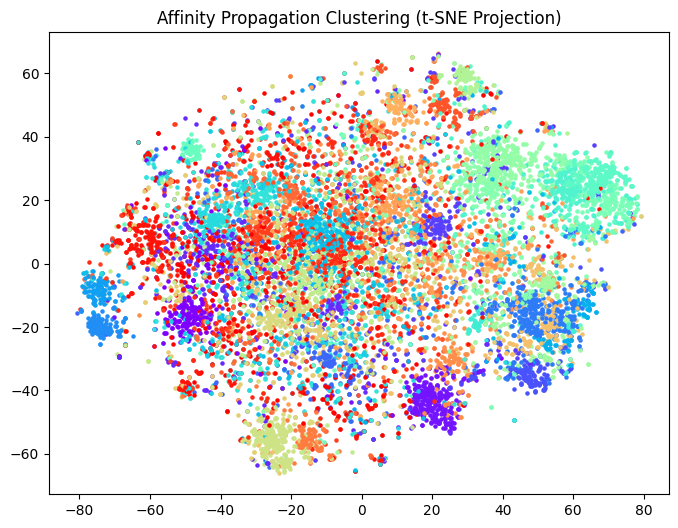

In [9]:
import matplotlib.pyplot as plt

# Visualize the clustering results in 2D:
plt.figure(figsize=(8, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, no_of_clusters))
for i in range(len(embeddings_2d)):
    plt.scatter(embeddings_2d[i][0], embeddings_2d[i][1], color = colors[embedding_cluster.labels_[i]], s=5)

plt.title('Affinity Propagation Clustering (t-SNE Projection)')
plt.show()

In [10]:
# Get the exemplars and their indices:
exemplars_indices = embedding_cluster.cluster_centers_indices_
exemplars = embeddings[exemplars_indices]

In [11]:
# Function to calculate Cosine Distances:
def get_cosine_dist(emb1,emb2):
    cosine_dist = 1 - (np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2)))
    return(cosine_dist)

In [12]:
# Get the cluster labels for the embeddings:
cluster_labels = embedding_cluster.labels_

# Populate indices belonging to each cluster:
cluster_indices = {}
for label in range(no_of_clusters):
    cluster_indices[label] = np.where(cluster_labels == label)[0]

In [13]:
# Find average cosine distance of embeddings within each cluster:
cosdist_list = []
for label, indices in cluster_indices.items():
    cluster_cosdist = []
    exemplar = exemplars[label]
    for index in indices:
        if index not in exemplars_indices:
            cluster_embedding = embeddings[index]
            cluster_cosdist.append(round(get_cosine_dist(exemplar, cluster_embedding),4))
    cosdist_dict={"Average":statistics.mean(cluster_cosdist),
                  "Minimum":min(cluster_cosdist),
                  "Maximum":max(cluster_cosdist)}
    cosdist_list.append(cosdist_dict)
    
# Print the result as a dataframe:
cosdist_df = pd.DataFrame(cosdist_list)
cosdist_df

,Average,Minimum,Maximum
0,0.397851,0.2098,0.6256
1,0.323642,0.1136,0.6604
2,0.428753,0.1935,0.7659
3,0.400288,0.1685,0.6579
4,0.316883,0.0854,0.7601
5,0.408376,0.2039,0.7569
6,0.357896,0.1898,0.7151
7,0.410527,0.2426,0.6582
8,0.467612,0.2689,0.7293
9,0.396853,0.1073,0.7377


In [14]:
# Find average cosine distance of exemplars within each cluster:
exemplar_list = []
for exemplar1 in exemplars:
    exemplar_cosdist = []
    for exemplar2 in exemplars:
        if np.all(exemplar1!=exemplar2):
            exemplar_cosdist.append(round(get_cosine_dist(exemplar1, exemplar2),4))
    exemplar_dict={"Average":statistics.mean(exemplar_cosdist),
                   "Minimum":min(exemplar_cosdist),
                   "Maximum":max(exemplar_cosdist)}
    exemplar_list.append(exemplar_dict)
    
# Print the result as a dataframe:
exemplar_df = pd.DataFrame(exemplar_list)
exemplar_df

,Average,Minimum,Maximum
0,0.562478,0.3456,0.9177
1,0.609359,0.3671,0.8372
2,0.551249,0.3427,0.8546
3,0.510614,0.2893,0.7368
4,0.679268,0.3519,0.8273
5,0.480868,0.2521,0.7729
6,0.554638,0.3542,0.7946
7,0.648478,0.4990,0.9203
8,0.629159,0.4442,0.8826
9,0.666473,0.3907,0.8431


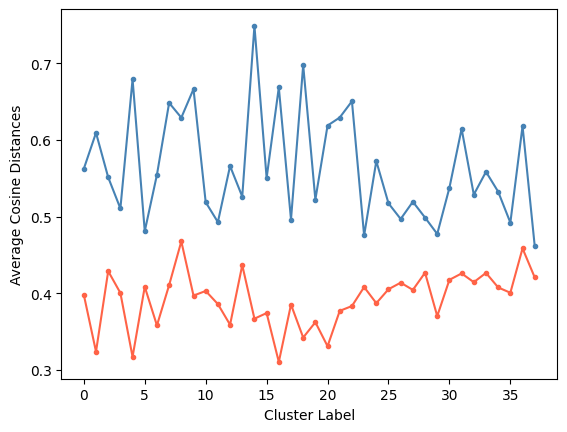

In [15]:
x1 = cosdist_df['Average']
x2 = exemplar_df['Average']

# Plotting the line graph:
plt.plot(x1, marker='.',color="tomato", linestyle='-')
plt.plot(x2, marker='.',color="steelblue", linestyle='-')

# Adding labels and title:
plt.xlabel('Cluster Label')
plt.ylabel('Average Cosine Distances')

# Display plot:
plt.show()

In [16]:
df["Cluster"] = cluster_labels

# Save the DataFrame as a CSV file:
df.to_csv('Clustering_Results_Cleaned.csv', index=False)
df

,Date,ID,Text,Cluster
0,26-Jul-17,1.010040e+11,Please call daughter dianne thomas 07920075650...,12
1,28-Jul-17,1.010040e+11,Please speak to sister alyson powell on abpve ...,1
2,28-Jul-17,1.010040e+11,Kelly has rung her parents are due to have wor...,15
3,31-Jul-17,1.010040e+11,"Mark hitchings, scheme manager swn yr afon con...",5
4,28-Jul-17,1.010040e+11,Son brian hasford run g he is resident in aust...,37
...,...,...,...,...
11362,13-Jun-23,1.010000e+11,"Enquiring about a downstairs toilet, states he...",19
11363,13-Jun-23,1.010000e+11,Phoning on behalf on her mother she has no fee...,29
11364,13-Jun-23,1.010000e+11,States on saturday they had to call an ambulan...,34
11365,13-Jun-23,1.010000e+11,Nadia obaji daughter of abdel obaji contacted ...,25


In [17]:
# Perform dimensionality reduction with t-SNE
tsne = TSNE(n_components=3, init='pca', random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

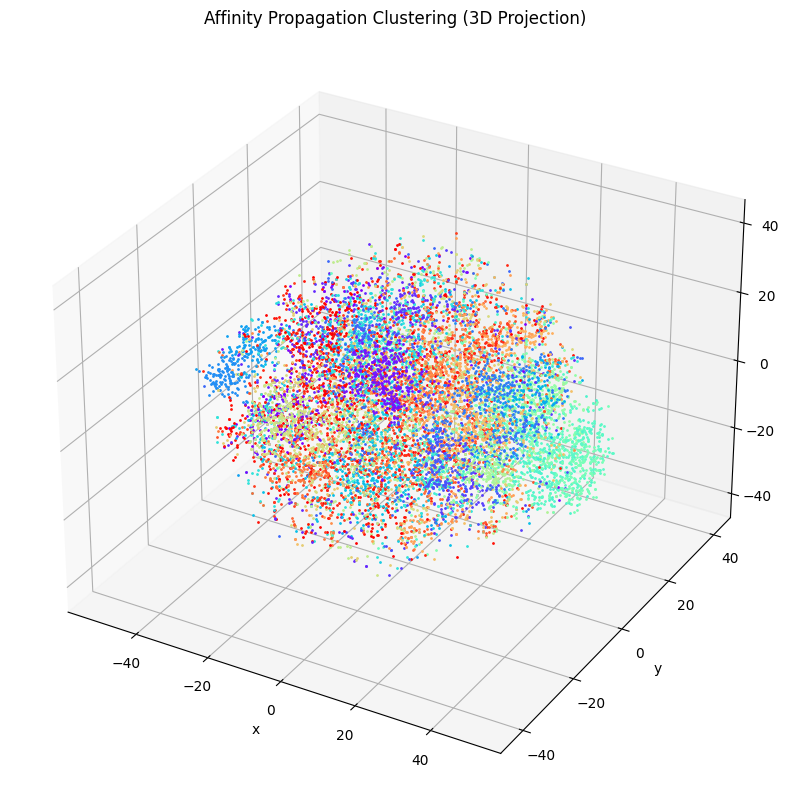

In [18]:
# Visualize the clustering results in 3D:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(embeddings_3d)):
    ax.scatter(embeddings_3d[i][0],embeddings_3d[i][1],embeddings_3d[i][2], color = colors[embedding_cluster.labels_[i]], s=1)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_facecolor('white')

plt.title('Affinity Propagation Clustering (3D Projection)')
plt.show()

In [19]:
# Function to clean text for TF-IDF:
def clean_text_for_TFIDF(text):
    # Remove newline characters:
    text = re.sub(r'[\n\r]+', '. ',text)
    # Only keep Alphabets, Digits and Spaces:
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert all phone numbers as a single token:
    text = re.sub(r'0\d{10}', 'phonetoken', text)
    # Convert to Lowercase:
    text = text.lower()
    return text

In [20]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Custom stop words to add
my_stop_words = ['mr','mrs','contact','urgent','phonetoken']
custom_stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)

for cluster_label in range(no_of_clusters):
    # Clean sentences by cluster and group them as a list:
    sentence_cluster = list(df[df["Cluster"]==cluster_label]["Text"].apply(clean_text_for_TFIDF))

    # Create a Document-Term Matrix
    vectorizer = TfidfVectorizer(stop_words=custom_stop_words)
    X = vectorizer.fit_transform(sentence_cluster)

    # Calculate the TF-IDF scores for the document-term matrix:
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X)

    # Convert the TF-IDF matrix to an array:
    X_tfidf_array = X_tfidf.toarray()

    # Rank Keywords for each sentence:
    top_keywords_per_sentence = []
    for i, sentence in enumerate(sentence_cluster):
        tfidf_scores = [(word, score) for word, score in zip(vectorizer.get_feature_names(), X[i].toarray()[0])]
        tfidf_scores.sort(key=lambda x: x[1], reverse=True)
        top_keywords_per_sentence.append(tfidf_scores)

    # Aggregate and Select Top Keywords:
    all_keywords = {}
    for keywords in top_keywords_per_sentence:
        for keyword, score in keywords:
            if keyword in all_keywords:
                all_keywords[keyword] += score
            else:
                all_keywords[keyword] = score

    # Select the top N keywords:
    top_n_keywords = sorted(all_keywords.items(), key=lambda x: x[1], reverse=True)[:5]
    print("\nCluster Label: {}".format(cluster_label))
    for keyword,score in top_n_keywords:
        print("    {} : {}".format(keyword,round(score,2)))


Cluster Label: 0
    worker : 19.01
    social : 18.05
    like : 14.7
    daughter : 10.06
    support : 9.21

Cluster Label: 1
    aids : 35.88
    equipment : 35.03
    assessment : 34.94
    request : 12.72
    daughter : 12.28

Cluster Label: 2
    davies : 16.56
    sally : 13.57
    care : 13.12
    daughter : 11.76
    prosser : 10.49

Cluster Label: 3
    assessment : 18.85
    mobility : 16.68
    tcall : 15.36
    thanks : 14.84
    michelle : 14.84

Cluster Label: 4
    bathing : 28.43
    assessment : 28.05
    difficulties : 12.03
    request : 10.57
    bath : 7.47

Cluster Label: 5
    assessment : 26.17
    carers : 17.49
    daughter : 14.45
    care : 13.59
    like : 11.99

Cluster Label: 6
    shower : 31.2
    bath : 26.87
    assessment : 26.47
    walk : 19.04
    struggling : 16.43

Cluster Label: 7
    medication : 10.72
    needs : 8.48
    prescription : 7.75
    pharmacy : 6.72
    today : 5.62

Cluster Label: 8
    food : 13.03
    client : 6.82
    needs

In [21]:
def keep_first_unique(labels):
    seen = set()
    unique = []
    for item in labels:
        if item not in seen:
            unique.append(item)
            seen.add(item)
    return unique

unique_cluster_labels = keep_first_unique(cluster_labels)

cluster_to_exemplar = {}
for label, exemplar_idx in zip(unique_cluster_labels, exemplars_indices):
    cluster_to_exemplar[label] = exemplar_idx
    
# Now you can access exemplar indices for each cluster label:
sorted_cluster_to_exemplar = {k:cluster_to_exemplar[k] for k in sorted(cluster_to_exemplar)}
for label, exemplar_idx in sorted_cluster_to_exemplar.items():
    print("Cluster {} \nExemplar: {}\n".format(label,df["Text"][exemplar_idx]))

Cluster 0 
Exemplar: Tel call wife mrs jones requested an assessment for some hand rails for husband to access front garden mr jones has copdangiogramcomplex needs and urgently needs an assessment his balance is out and is falling constantly when leaving the house she has had a call few weeks ago as requested this previously but no update as yet

Cluster 1 
Exemplar: Call from grand daughter please call her on 07840408982 difficulties bathing would like referral asking for walk in shower thanks abi

Cluster 2 
Exemplar: Edwards, raymond mr id: 2194307 urgent referral received by contact centre. . contact made 16:08 mr raymond edwards and mrs tatiana edwards state their prescription is ready to be collected from taffs well pharmacy however, they are self isolationg and do not have anyone who can collect for them. mr edwards took his last lot of medication today.

Cluster 3 
Exemplar: Tcall mrs murphy states carer turning up and thowing things and hurt foot its all black and stolen over 

In [22]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from gensim import corpora, models

# Function to tokenize text:
def tokenize_text(text):
    # Tokenize sentences:
    sentences = sent_tokenize(text)
    # Tokenize words:
    words = []
    for sentence in sentences:
        words += word_tokenize(sentence)
    return words

# Function to remove stopwords:
def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return words

for cluster_label in range(no_of_clusters):
    # Clean sentences by cluster and group them as a list:
    sentence_cluster = list(df[df["Cluster"]==cluster_label]["Text"].apply(clean_text_for_TFIDF))
    tokenized_cluster = [tokenize_text(sentence) for sentence in sentence_cluster]
    token_cluster = [remove_stopwords(sentence_tokens) for sentence_tokens in tokenized_cluster]
    
    # Create a dictionary and a corpus:
    dictionary = corpora.Dictionary(token_cluster)
    corpus = [dictionary.doc2bow(doc) for doc in token_cluster]
    
    # Applying LDA:
    lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary)